# Context

This project aims to build **a classification model that will be able to correctly identify which subreddit a post belongs to**. Such a classification model may be **useful for Reddit as a company or even a subreddit moderators* to make sure that the posts that are shown on the subreddit are relevant to the community.**


**The scope of this project** is limited to two very similar subreddits, namely: [r/COVID19_support](https://www.reddit.com/r/COVID19_support/) and [r/COVID19positive](https://www.reddit.com/r/COVID19positive/).

These two subreddits are chosen as their names are very similar and hence, some users may not be posting at the right subreddit. These two subreddits are actually created for **very different purposes:**

>**COVID19_support** is a subreddit **offering help and support** for those people who are **affected by the current COVID situation**. However, it is not really for people who are infected by the virus. It is for those who are **affected financially, emotionally or mentally.** For example, there are people who **lost their jobs or people who simply feel depressed because they are staying alone without any social interactions.**


>**COVID19positive** is for those who **have been infected by the virus to share their experience and support those who suspect that they may have the virus/have family members who have been infected.**


Even though, these two subreddits may sound similar in nature, it is important that **the right posts are showing up on the two subreddits so that people who have gone through similar experience will be able to support/comfort those who need help.** For instance, if people start ranting about being jobless on COVID19 positive channel, it will be frustrating for those who are actually looking for advice/help on swab-test/treatment options. Similary, if a suspected COVID19 person is seeking for advice regarding treatment will not be able to find very constructive advice on COVID19_support subreddit. 



* Note: subreddit moderators: people who are responsible for maintaining a particular subreddit

# Problem Statement

This report will help us do the following things: 

- Create a model that will **identify if a post should belong to COVID19_support or COVID19positive subreddit** using the **post title and content**
- Identify **unique features/words that frequently occur** in each subreddit

I will be comparing two different models: **Logistic Regression and Naive Bayes Model**. Since in this context, **correctly identifying one subreddit is not more important than the other,** I will be using **accuracy score as the main metric to evaluate my models**


**Covid19 Support will be classified as Class 1** while **COVID19 Positive will be classified as class 0**

---

# Content

Please refer to this notebook for the codes on data collection: [Project 3: COVID Subreddits Part 1](https://github.com/elisenerissa/dsiprojects/blob/master/project_3/Project%203%20-%20Part%201%20Covid.ipynb)

- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Pre-processing](#Pre-processing)
- [Modeling](#Modeling)
- [Findings and Analysis](#Inferential-Findings-and-Analysis)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)
- [Future Steps](#Future-Steps)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

plt.style.use('fivethirtyeight')
%matplotlib inline

#more libraries will be imported along the way

# Data Import and Cleaning

### Data Import

In [2]:
#reading in the two csv files that were previously collected on previous notebook

covid_pos = pd.read_csv('./datasets/covid_positive.csv')
covid_support = pd.read_csv('./datasets/covid_support.csv')

In [3]:
#showing the first two rows of covid positive dataframe
covid_pos.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview,crosspost_parent_list,crosspost_parent,poll_data,author_cakeday
0,NaN,COVID19positive,"As per the rules, posts are only allowed to be...",t2_6l4z3,False,NaN,0,False,"Daily Discussion - May 09, 2020",[],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,COVID19positive,"As per the rules, posts are only allowed to be...",t2_6l4z3,False,NaN,0,False,"Weekly ""I Think I Have It"" Thread - Week of Ma...",[],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#showing the first two rows of covid support dataframe
covid_support.head(2)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,crosspost_parent_list,crosspost_parent
0,NaN,COVID19_support,**New Users**\n\nPlease contact the moderators...,t2_5bwlzn40,False,NaN,0,False,"NEW Welcome, Approvals and Flairs","[{'e': 'text', 't': 'News'}]",...,https://www.reddit.com/r/COVID19_support/comme...,22503,1.585290e+09,0,NaN,False,NaN,NaN,NaN,NaN
1,NaN,COVID19_support,Plenty of good news from around the world this...,t2_qi9u7,False,NaN,0,False,WEEKLY GOOD NEWS STICKY: 4-10 May 2020,[],...,https://www.reddit.com/r/COVID19_support/comme...,22503,1.588543e+09,0,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN


### Data Cleaning : Covid Positive Subreddit

**Removing Duplicates**

In [5]:
#shape of covid positive dataframe
covid_pos.shape

(980, 110)

In [6]:
#find out how many duplicate posts there are
covid_pos.duplicated(subset=['title','selftext']).sum()

34

In [7]:
#drop the duplicates
covid_pos.drop_duplicates(subset = ['title','selftext'],keep='first',inplace=True)

In [8]:
#checking that the duplicated rows have been dropped
covid_pos.shape

(946, 110)

In [9]:
def all_text(row):
    """ a function to merge the title and selftext of the posts"""
    row['posts'] = str(row['title']) + " " + str(row['selftext'])
    return row 

In [10]:
#merging title and selftext on covid posts under a column called posts
covid_pos = covid_pos.apply(all_text, axis=1)

In [11]:
#May 16, 2020
#convert date to age. assuming that today is 16th May 2020
import datetime

may_16 = datetime.datetime(2020, 5, 16)
may_16.strftime("%x")

'05/16/20'

In [12]:
import time

def convert_time(timestamp):
    """to convert unix timestamp to human readable date format"""
    ts = time.gmtime(timestamp)
    date = time.strftime("%x", ts)
    return date

#create a new column called date
covid_pos ['date'] = covid_pos['created_utc'].map(convert_time)
covid_pos ['date'] = pd.to_datetime(covid_pos ['date'])
covid_pos['may_16'] = may_16

In [13]:
#create a new column called age (May 16 - the date of the post )
covid_pos['age'] = covid_pos['may_16'] - covid_pos['date'] 

In [14]:
#convert the age format to days
covid_pos['age']= covid_pos['age'].dt.days

As future deployment of the model will be **done using only the title and content of the posts** (based on problem statement), we will not be using any of the other features from the data that we have collected. However, we will explore some of the interesting features to understand more about each subreddits.

In [15]:
#only select the columns that are relevant
covid_pos_sub = covid_pos[['subreddit','posts','num_comments','age','upvote_ratio']]

In [16]:
#checking for null values for relevant columns 
covid_pos_sub.isnull().sum()

subreddit       0
posts           0
num_comments    0
age             0
upvote_ratio    0
dtype: int64

In [17]:
covid_pos_sub.dtypes

subreddit        object
posts            object
num_comments      int64
age               int64
upvote_ratio    float64
dtype: object

No null values and the data types are correct

In [18]:
#confirm the shape
covid_pos_sub.shape

(946, 5)

### Data Cleaning : Covid Support Subreddit

#### Remove Duplicates

In [19]:
#showing the shape of covid support dataframe
covid_support.shape

(827, 108)

In [20]:
#showing the total number of duplicates 
covid_support.duplicated(subset=['title','selftext']).sum()

2

In [21]:
#drop duplicates
covid_support.drop_duplicates(subset = ['title','selftext'],keep='first',inplace=True)

In [22]:
#show the shape to verify the drop
covid_support.shape

(825, 108)

In [23]:
#apply the function created earlier to merge the title and selftext into a new column called posts
covid_support = covid_support.apply(all_text, axis=1)

In [24]:
#create a new column called date and may_16 to calculate age 

covid_support['date'] = covid_support['created_utc'].map(convert_time)
covid_support['date'] = pd.to_datetime(covid_support['date'])
covid_support['may_16'] = may_16

In [25]:
#create a new column called age
covid_support['age'] = covid_support['may_16'] - covid_support['date'] 

In [26]:
#reformat age 
covid_support['age']= covid_support['age'].dt.days

In [27]:
#taking the same subset of columns from the dataframe 
covid_support_sub = covid_support[['subreddit','posts','num_comments','age','upvote_ratio']]

In [28]:
#confirming the shape of covid_support_sub
covid_support_sub.shape

(825, 5)

In [29]:
#checking for null values
covid_support_sub.isnull().sum()

subreddit       0
posts           0
num_comments    0
age             0
upvote_ratio    0
dtype: int64

In [30]:
#checking for data types
covid_support_sub.dtypes

subreddit        object
posts            object
num_comments      int64
age               int64
upvote_ratio    float64
dtype: object

No null values and the data types are correct.

### Concatenate the two dataframes

In [31]:
#concat the two dataframes 
combined_df = pd.concat([covid_pos_sub,covid_support_sub],axis=0)

In [32]:
#check the shape of the newly combined df
combined_df.shape

(1771, 5)

In [33]:
#reset the index
combined_df.reset_index(drop=True,inplace=True)

In [34]:
#check for null values
combined_df.isnull().sum()

subreddit       0
posts           0
num_comments    0
age             0
upvote_ratio    0
dtype: int64

In [35]:
#map the categories 
#Covid support: class 1
#Covid positive: class 0
combined_df['categories'] = combined_df['subreddit'].map({'COVID19_support':1,'COVID19positive':0})

In [36]:
#checking if the two classes are balanced
combined_df['categories'].value_counts(normalize=True)

0    0.534161
1    0.465839
Name: categories, dtype: float64

The proportion of our target variables are quite balanced.

In [37]:
def clean_posts(raw_post):
    """
    Function to convert a raw post to a string of words that have been cleaned. 
    - HTML, non-letters will be removed
    - words will be converted to lowercase
    - stopwords will be removed 
    - words will be stemmed to their root words
    
    The input is a single string, and 
    the output is a single string 
    
    """
    
    # Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # Stemming 
    p_stemmer = PorterStemmer()
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

**Cleaning  Posts from Two Separate Dataframes**

In [38]:
# Initialize an empty list to hold the clean posts
clean_covidpos_posts = []
clean_covidsup_posts= []

print("Cleaning and parsing the covid positive posts...")

# Instantiate counter.
j = 0

# For every post in covid positive dataframe
for post in covid_pos_sub['posts']:
    
    # Apply the function that we created earlier to clean the posts
    clean_covidpos_posts .append(clean_posts(post))
    
    j += 1


print("Cleaning and parsing the covid support reddit posts...")

#For every post in covid positive dataframe
for post in covid_support_sub['posts']:
    
    # Apply the function that we created earlier to clean the posts
    clean_covidsup_posts.append(clean_posts(post))
    j += 1

print("Completed")

Cleaning and parsing the covid positive posts...
Cleaning and parsing the covid support reddit posts...
Completed


## Cleaning Combined DF

The reason why I am cleaning the combined df is so that it will be easy to manipulate the data while doing EDA.

In [39]:
# Initialize an empty list to hold the clean posts
clean_combined_posts = []

print("Cleaning and parsing the combined posts...")

# Instantiate counter.
j = 0

# For every review in our combined dataframe
for post in combined_df['posts']:
    
    # Apply the function that we created earlier to clean the posts
    clean_combined_posts.append(clean_posts(post))
    
    j += 1

print("Completed")

Cleaning and parsing the combined posts...
Completed


In [40]:
#adding the cleaned posts in the dataframe 
combined_df['cleaned_posts'] = clean_combined_posts

In [41]:
#creating a word count columns
combined_df['word_count'] = combined_df['posts'].apply(lambda x: len(str(x).split()))

In [42]:
#confirming the changes made to dataframe
combined_df.head(2)

,subreddit,posts,num_comments,age,upvote_ratio,categories,cleaned_posts,word_count
0,COVID19positive,"Daily Discussion - May 09, 2020 As per the rul...",1,7,1.00,0,daili discuss may per rule post allow first ha...,36
1,COVID19positive,"Weekly ""I Think I Have It"" Thread - Week of Ma...",249,13,0.88,0,weekli think thread week may per rule post all...,43


In [43]:
#checking the datatypes of combined df after adding more columns
combined_df.dtypes

subreddit         object
posts             object
num_comments       int64
age                int64
upvote_ratio     float64
categories         int64
cleaned_posts     object
word_count         int64
dtype: object

## Exploratory Data Analysis

Before exploring the data, here is the data dictionary of the columns that we are going to explore:

|Column Name|Data Type|Description|
|---|---|---|
|**subreddit**|*object*|COVID19 Positive or COVID19 Support| 
|**posts**|*object*|The title and content of posts|
|**num_comments**|*integer*|The number of comments in each post|
|**age**|*integer*|The age of the post (calculated from 16th May) eg. 16-05-2020 minus the date the post was created|
|**upvote_ratio**|*float*|The percentage of upvotes over the total votes|
|**word_count**|*integer*|The number of words in each post|
|**categories**|*integer*|Subreddit that has been converted to integer format. COVID19 Positive is 0 and COVID19 Support is 1|

In [44]:
#looking at the number of comments statistics
combined_df.groupby('categories')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
categories,,,,,,,,
0,946.0,165.445032,206.916019,2.0,53.25,107.5,202.5,2806.0
1,825.0,234.933333,230.088315,4.0,95.00,172.0,297.0,2182.0


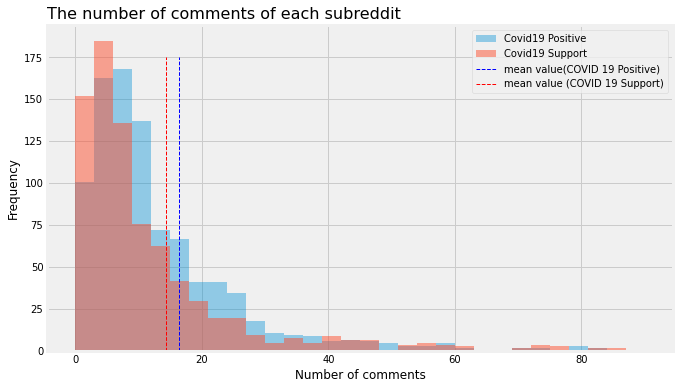

In [45]:
#Set figure size
plt.figure(figsize=(10,6))

#Plot histogram
covid_pos_sub['num_comments'].plot.hist(label='Covid19 Positive',range=(0,90),bins=30,alpha=0.4)
covid_support_sub['num_comments'].plot.hist(label= 'Covid19 Support',range=(0,90),bins=30,alpha=0.5)

#Set title and labels
plt.title("The number of comments of each subreddit",fontsize=16,loc='left')
plt.xlabel("Number of comments",fontsize=12)

#set the mean line
plt.vlines(np.mean(covid_pos_sub['num_comments']), ymin = 0, ymax = 175,
           color='blue', label = 'mean value(COVID 19 Positive)',linestyle= '--', lw=1)
plt.vlines(np.mean(covid_support_sub['num_comments']), ymin = 0, ymax = 175,
           color='red', label = 'mean value (COVID 19 Support)',linestyle= '--', lw=1)


plt.legend()
plt.show()

#plt.hist(combined_df['word_count'])

We can see that the distributions of number of comments in both subreddits are **pretty similar with an average of 14-16 comments per posts.** There are also posts that receive more than 50 comments even though there are not a lot. This histogram shows that **both communities are pretty supportive in nature.** 

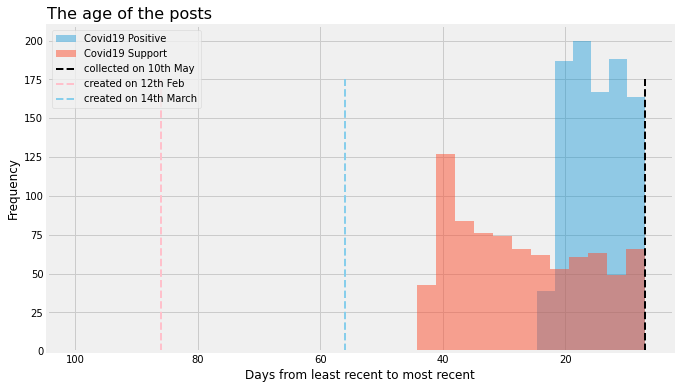

In [46]:
plt.figure(figsize=(10,6))
covid_pos_sub['age'].plot.hist(label='Covid19 Positive',range=(7,95),bins=30,alpha=0.4)
covid_support_sub['age'].plot.hist(label= 'Covid19 Support',range=(7,100),bins=30,alpha=0.5)
plt.title("The age of the posts",fontsize=16,loc='left')
plt.xlabel("Days from least recent to most recent",fontsize=12)

# Add vertical line at the date the post was collected
plt.vlines(x=7.0,
           ymin = 0,
           ymax = 175,
           label = 'collected on 10th May',
           color='black',
           linestyle = '--', lw=2)

# Add vertical line at the date the subreddit is created
plt.vlines(x=86.0,
           ymin = 0,
           ymax = 175,
           label = 'created on 12th Feb',
           color='pink',
           linestyle = '--', lw=2)



# Add vertical line at the date the subreddit is created
plt.vlines(x=56.0,
           ymin = 0,
           ymax = 175,
           label = 'created on 14th March',
           color='skyblue',
           linestyle = '--', lw=2)


plt.gca().invert_xaxis()
plt.legend()
plt.show()

We can see that the COVID19 Support only **started becoming active about 45 days ago,** which is about end of March/beginning of April. This **coincides with the time when COVID-19 started to have significant increase in the number of cases globally (largely contributed by the United States).** 

See graph below: 
(Source of the graph below:[Worldometer](https://www.worldometers.info/coronavirus/)). 

![Global Cases vs Time](./datasets/covid19_global_cases.png) 

The COVID19 Positive subreddit also **started becoming active much later (about 20 days later).** However, we can see that COVID19 Positive receive a lot more posts on a daily basis as compared to COVID19 Support. This is likely due to the increasing number of positive cases.

On top of that, **54% of Reddit users are from US.** (Source: [Website Builder](https://websitebuilder.org/reddit-statistics/)). This may be the reason why the two subreddits started becoming very active from end of March/early April.

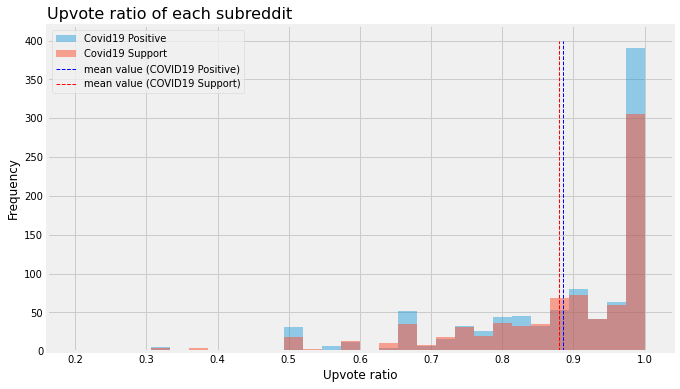

In [47]:
#Set figure size
plt.figure(figsize=(10,6))

#Plot histogram 
covid_pos_sub['upvote_ratio'].plot.hist(label='Covid19 Positive',range=(0.2,1),bins=30,alpha=0.4)
covid_support_sub['upvote_ratio'].plot.hist(label= 'Covid19 Support',range=(0.2,1),bins=30,alpha=0.5)

#Set title and labels
plt.title("Upvote ratio of each subreddit",fontsize=16,loc='left')
plt.xlabel("Upvote ratio",fontsize=12)

#set the mean line
plt.vlines(np.mean(covid_pos_sub['upvote_ratio']), ymin = 0, ymax = 400,
           color='blue', label = 'mean value (COVID19 Positive)',linestyle= '--', lw=1)
plt.vlines(np.mean(covid_support_sub['upvote_ratio']), ymin = 0, ymax = 400,
           color='red', label = 'mean value (COVID19 Support)',linestyle= '--', lw=1)


plt.legend()
plt.show()

From the histogram above, we can see that the upvote ratio is generally quite high. Again, this shows that the communities in both subreddits are pretty supportive. 

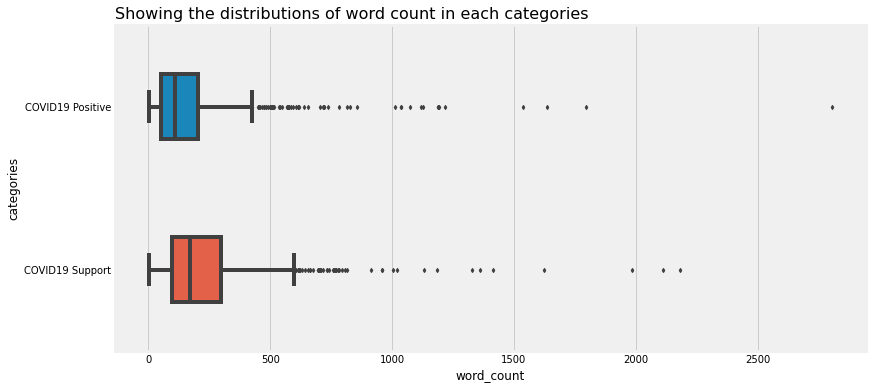

In [48]:
import seaborn as sns

#set figure size
plt.figure(figsize=(12,6))


#plot boxplot
word_count = sns.boxplot(data= combined_df, y= 'categories', x= 'word_count',orient='h',width=0.4,fliersize=3);

#Set title and labels 
word_count.set_yticklabels(['COVID19 Positive', 'COVID19 Support']);
word_count.set_title("Showing the distributions of word count in each categories",fontsize=16,loc='left');

There are higher number of wordcounts in COVID19 Support than COVID19 Positive Subreddits. However, this does not tell us a lot as both subreddits are considered pretty lengthy in content as they are mostly stories/rants/sharing of experiences.

In [49]:
def get_one_gram(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [50]:
#get the top 20 most frequently occuring words by applying the function above
covidpos = dict(get_one_gram(clean_covidpos_posts,20))
covidsup = dict(get_one_gram(clean_covidsup_posts,20))

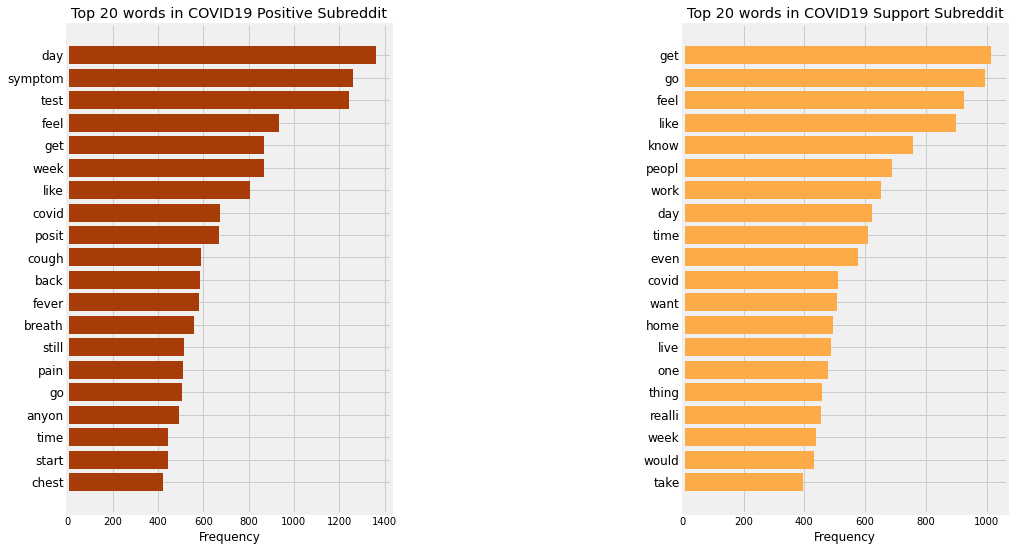

In [51]:
#Create subplots
fig, axes = plt.subplots(1,2, figsize=(15,9));

#plot covid 19 positive top 20 most frequently occuring words
plt.subplot(1,2,1)
covid_pos = plt.barh(range(len(covidpos)), covidpos.values(),align = 'center',color='xkcd:rust');

#Label axes 
plt.yticks(range(len(covidpos)),covidpos.keys(),fontsize=12);
plt.title('Top 20 words in COVID19 Positive Subreddit')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()



#plot covid 19 support top 20 most frequently occuring words
plt.subplot(1,2,2)
covid_pos = plt.barh(range(len(covidsup)), covidsup.values(),align = 'center',color='xkcd:light orange');

#Label axes
plt.yticks(range(len(covidsup)),covidsup.keys(),fontsize=12);
plt.title('Top 20 words in COVID19 Support Subreddit')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

plt.subplots_adjust(wspace=0.9)
plt.show()

The above shows the top 20 words in each subreddit before they are fed into the model. I would remove **covid, positive and support** from hereon to avoid target leakage. I would also **add "feel" and "like"** into my stopwatch as they are happening so frequently in both subreddits. 


Also, it seems like there is a clear distinction of the words usage and content in these two subreddits. It seems like we will be able to answer our problem statement afterall. We will evaluate it again below.

# Pre-processing

In [52]:
#additional stopwords added
additional_stopwords = ['covid','positive','support','feel','like','nan']

Note: I am also adding **nan as one of the stopwords as it appeared in my top 20 words** after I've trained my models.

In [53]:
def remove_more_stopwords(clean_post):
    """remove additional stop words - takes in a string of words and returns a single string"""
    words = clean_post.lower().split()
    meaningful_words = [w for w in words if w not in additional_stopwords]
    return(" ".join(meaningful_words))

In [54]:
#removing additional stopwords from cleaned post column
combined_df['cleaned_posts'] = combined_df['cleaned_posts'].map(remove_more_stopwords)

In [55]:
# Create the feature and target variable
X = combined_df['cleaned_posts']
y = combined_df['categories']

### Train/Test Split

In [56]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify= y)

# Modeling

### Instantiating Models

In [57]:
# Import libraries for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

### Baseline Model

In [58]:
y_train.value_counts(normalize=True)
#our baseline accuracy is 53% 

0    0.533886
1    0.466114
Name: categories, dtype: float64

Our baseline model is giving us an accuracy of 53%. It means that if we assign **every post to class 0, we will get 53% correct**

### Logistics Regression: CVEC vs TDIF vectorizers

In [59]:
#Instantiate the pipeline
lr_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr',LogisticRegression(random_state=42,solver='liblinear', max_iter=10000))
])

#create hyperparameters for gridsearch
lr_cvec_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.9,0.95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__C':[0.01,0.1,1,10],
    'lr__penalty': ['l1', 'l2']
}

# Instantiate GridSearchCV.
lr_cvec_gs = GridSearchCV(lr_cvec_pipe, # what object are we optimizing?
                  param_grid=lr_cvec_params , # what parameters values are we searching?
                  cv=5,
                 n_jobs=-1) 

#fit the model
lr_cvec_gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [60]:
#instantiate pipeline
lr_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr',LogisticRegression(solver='liblinear', max_iter=10000,random_state=42))
])

#create hyperparameters for gridsearch
lr_tvec_params = {
    'tvec__max_features': [500,1000,2000,3000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.85,0.9],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__C':[0.01,0.1,1,10],
    'lr__penalty': ['l1', 'l2']
}

#instantiate gridsearchCV
lr_tvec_gs = GridSearchCV(lr_tvec_pipe, # what object are we optimizing?
                  param_grid=lr_tvec_params , # what parameters values are we searching?
                  cv=5,
                 n_jobs=-1) 

#fit the model
lr_tvec_gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

### Naive Bayes: CVEC vs TDIF vectorizers

In [61]:
#instantiate pipeline
nb_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb',MultinomialNB())
])

#create hyperparameters for gridsearch
nb_cvec_params = {
    'cvec__max_features': [500,1000,2000,3000],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.85,0.9],
    'cvec__ngram_range': [(1,1), (1,2)],
}

#instantiate gridsearchCV
nb_cvec_gs = GridSearchCV(nb_cvec_pipe, # what object are we optimizing?
                  param_grid=nb_cvec_params , # what parameters values are we searching?
                  cv=5,
                 n_jobs=-1) 


#fit the model 
nb_cvec_gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [62]:
#instantiate pipeline
nb_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb',MultinomialNB())
])

#create hyperparameters
nb_tvec_params = {
    'tvec__max_features': [500,1000,2000,3000],
    'tvec__min_df':[2,3],
    'tvec__max_df':[0.85,0.9],
    'tvec__ngram_range': [(1,1), (1,2)]
}

#instantiate gridsearch
nb_tvec_gs = GridSearchCV(nb_tvec_pipe, # what object are we optimizing?
                  param_grid=nb_tvec_params , # what parameters values are we searching?
                  cv=5,
                 n_jobs=-1) 

#fit the model
nb_tvec_gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

### Comparing Accuracy Scores

In [63]:
baseline_model = y_train.value_counts(normalize=True)
baseline_accuracy = round(baseline_model[0],3)

print(f"Baseline accuracy: {baseline_accuracy}")

Baseline accuracy: 0.534


As mentioned before, the baseline model is giving us an accuracy of 53%. It means that if we assign **every post to class 0, we will get 53% correct**


Our model has to **perform better than the baseline accuracy shown above**. Otherwise, it will be pointless to deploy the model. 

In [64]:
training_accuracy_score = round(lr_cvec_gs.score(X_train,y_train),3)
testing_accuracy_score = round(lr_cvec_gs.score(X_test,y_test),3)

print(f"Logistic Regression CVEC Train Accuracy Score: {training_accuracy_score}")
print(f"Logistic Regression CVEC Test Accuracy Score: {testing_accuracy_score}")

Logistic Regression CVEC Train Accuracy Score: 0.899
Logistic Regression CVEC Test Accuracy Score: 0.869


In [65]:
train_accuracy = round(lr_tvec_gs.score(X_train,y_train),3)
test_accuracy = round(lr_tvec_gs.score(X_test,y_test),3)


print(f"Logistic Regression TFID Train Accuracy Score: {train_accuracy}")
print(f"Logistic Regression TFID Test Accuracy: {test_accuracy}")

Logistic Regression TFID Train Accuracy Score: 0.931
Logistic Regression TFID Test Accuracy: 0.903


The Logistic Regression model seems to perform better with TF-IDF Vectorizer as compared to CountVectorizer as seen on the two accuracy scores above on the test data. The model that uses TF-IDF Vectorizer has an accuracy score of 90.3% while the model that uses CountVectorizer has an accuracy score of 86.9%.

The two models also seem to be an overfit as the training accuracy score is higher than the test accuracy score. 

In [66]:
train_accuracy = round(nb_cvec_gs.score(X_train,y_train),3)
test_accuracy = round(nb_cvec_gs.score(X_test,y_test),3)


print(f"Naive Bayes CVEC Train Accuracy Score: {train_accuracy}")
print(f"Naive Bayes CVEC Test Accuracy Score: {test_accuracy}")

Naive Bayes CVEC Train Accuracy Score: 0.889
Naive Bayes CVEC Test Accuracy Score: 0.898


In [67]:
train_accuracy = round(nb_tvec_gs.score(X_train,y_train),3)
test_accuracy = round(nb_tvec_gs.score(X_test,y_test),3)

print(f"Naive Bayes TFID Train Accuracy Score: {train_accuracy}")
print(f"Naive Bayes TFID Test Accuracy Score: {test_accuracy}")

Naive Bayes TFID Train Accuracy Score: 0.898
Naive Bayes TFID Test Accuracy Score: 0.907


In general, **Naive Bayes models are performing better than our Logistic Regression models.** They also **do not show signs of overfitting** as both Naive Bayes models train accuracy scores are very close to the test accuracy scores (even though there is **a very slight underfit**). 

We can see from the above that **our Naive Bayes model using TFID Vectorizer** is the best performing model. Hence, we will be using it as our final model for predictions.

## Fitting our entire training dataset to the best model

In [68]:
nb_tvec_gs.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [69]:
best_tvec_nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_df= 0.85,
     max_features= 3000,
     min_df= 2,
     ngram_range= (1, 2))),
    ('nb',MultinomialNB())
])

best_tvec_nb_pipe.fit(X_train,y_train)
train_accuracy = best_tvec_nb_pipe.score(X_train,y_train)
test_accuracy = best_tvec_nb_pipe.score(X_test,y_test)

print(f"Final train accuracy: {train_accuracy}")
print(f"Final test accuracy: {test_accuracy}")

Final train accuracy: 0.8975903614457831
Final test accuracy: 0.90744920993228


As we can see, the accuracy did not change after fitting it into the entire training dataset.

# Inferential Findings and Analysis

In [70]:
#finding the empirical log probability of features given a class
#the values that we will get will be proportional to the conditional probability of each class
top_features_pos_class = best_tvec_nb_pipe.named_steps['nb'].feature_log_prob_[1]
top_features_neg_class = best_tvec_nb_pipe.named_steps['nb'].feature_log_prob_[0]
feature_names = best_tvec_nb_pipe.named_steps['tvec'].get_feature_names()

In [71]:
#Covid support top 20 words
#I am going to plot a graph to show the visuals of the top words
#Hence, I am doing a np.exp as the empirical log probabilites given were negative. 
covid_support = dict(pd.Series(np.exp(top_features_pos_class), feature_names).sort_values(ascending=False).head(20))

In [72]:
#Covid positive
covid_positive = dict(pd.Series(np.exp(top_features_neg_class), feature_names).sort_values(ascending=False).head(20))

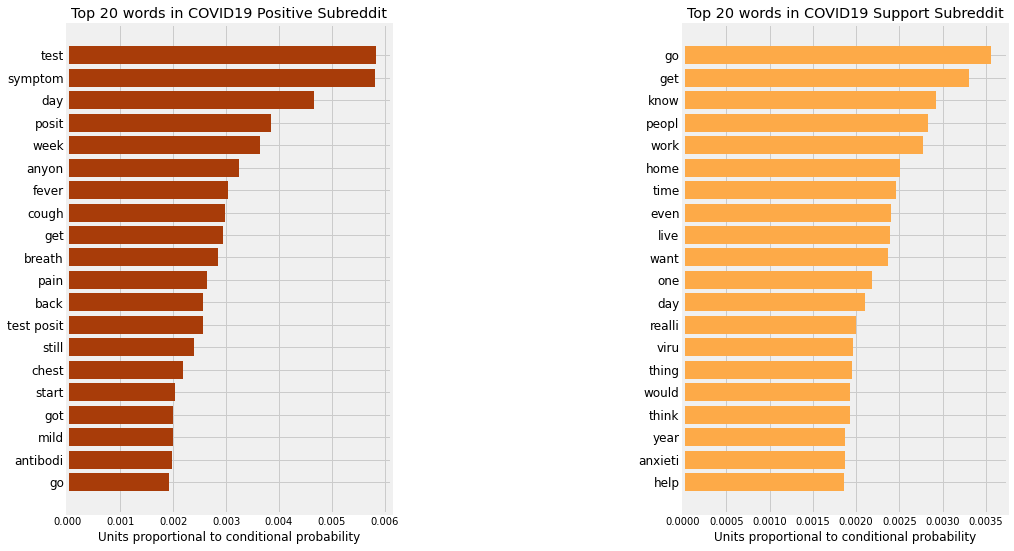

In [73]:
#Create subplots and set figuresize
fig, axes = plt.subplots(1,2, figsize=(15,9));


#Plot covid positive top 20 words 
plt.subplot(1,2,1)
covid_pos = plt.barh(range(len(covid_positive)), covid_positive.values(),align = 'center',color='xkcd:rust');

#Label axes
plt.yticks(range(len(covid_positive)),covid_positive.keys(),fontsize=12);
plt.title('Top 20 words in COVID19 Positive Subreddit')
plt.xlabel('Units proportional to conditional probability')
plt.gca().invert_yaxis()


#Plot covid support top 20 words 
plt.subplot(1,2,2)
covid_pos = plt.barh(range(len(covid_support)), covid_support.values(),align = 'center',color='xkcd:light orange');
plt.yticks(range(len(covid_support)),covid_support.keys(),fontsize=12);
plt.title('Top 20 words in COVID19 Support Subreddit')
plt.xlabel('Units proportional to conditional probability')
plt.gca().invert_yaxis()

#adjust the space between the subplots
plt.subplots_adjust(wspace=0.9)
plt.show()

The above are the top 20 words that are generated from the model. We can see that the COVID-19 Positive subreddit is mostly describing one's physical conditions with words like back, pain, fever, cough while COVID-19 Support posts are more emotions-based with words like anxiety, help. 

## Predictions

In [74]:
#predicting the target variables with our best model
pred = best_tvec_nb_pipe.predict(X_test)

In [75]:
#get the probability of each class in each post
predict_prob = best_tvec_nb_pipe.predict_proba(X_test)
predict_prob[:5]

array([[0.51593524, 0.48406476],
       [0.82541572, 0.17458428],
       [0.81171491, 0.18828509],
       [0.58971092, 0.41028908],
       [0.94954904, 0.05045096]])

In [76]:
#find class 1 probability
class_1_prob = [round(ele[1],3) for ele in predict_prob]

In [77]:
#create a dataframe of the actual class vs predictions 
results = pd.DataFrame(X_test, columns=['cleaned_posts'])
results['actual'] = list(y_test)
results['predictions'] = pred

#also added the probability of class 1 as one of the columns
results['class1_prob'] = class_1_prob

In [78]:
#create a dataframe just showing the wrong predictions
wrong_pred = results[results['actual'] != results['predictions']]
wrong_pred.head()

,cleaned_posts,actual,predictions,class1_prob
1141,could infect throat start hurt last day tri sc...,1,0,0.484
1363,breath second keep read post breath hold breat...,1,0,0.272
282,would love chat someon surviv major case would...,0,1,0.517
642,send someon w found today close famili member ...,0,1,0.520
384,week debat go hospit exposur possibl make wors...,0,1,0.608


In [79]:
# Import confusion_matrix.
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [80]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test,
                                  pred).ravel()

#true negatives/all negatives
specificity = round(tn/(tn+fp),3)

#true positives/all positives
sensitivity= round(tp/(tp+fn),3)

print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Specificity: 0.916
Sensitivity: 0.898


This means that 91.6% of COVID 19 positive posts were classified correctly while 89.8% of COVID19 Support posts were classified correctly. However, in this case, **the accuracy score would be more important as both classes are equally as important according to our problem statement.** 

Both errors are equally bad because most people seeking advice in COVID19 support **could be equally as desperate/sad** as people in COVID19 positive.

However, just for clarity sake, I have plotted **the confusion matrix** below. 

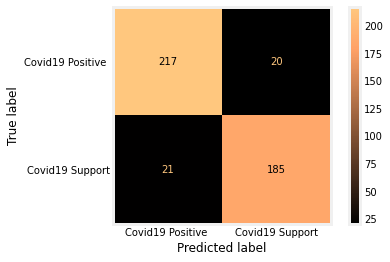

In [81]:
plot_confusion_matrix(best_tvec_nb_pipe, X_test, y_test,
                      values_format = 'd',
                      display_labels = ["Covid19 Positive ","Covid19 Support"],
                     cmap='copper')

plt.grid(False)
plt.show()

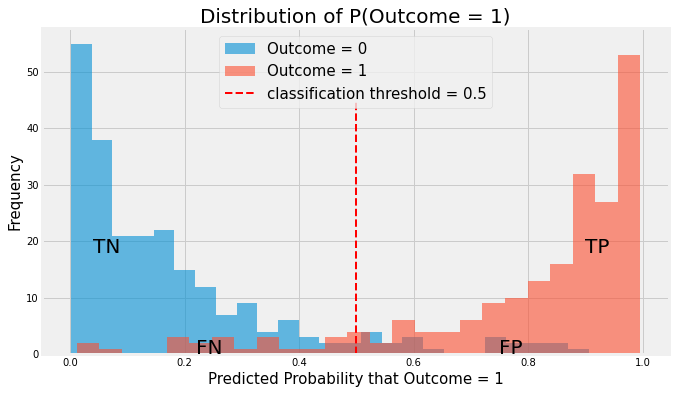

In [82]:
# Create figure.
plt.figure(figsize = (10,6))

# Create two histograms of observations.
plt.hist(results[results['actual'] == 0]['class1_prob'],
         bins=25,
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(results[results['actual'] == 1]['class1_prob'],
         bins=25,
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 45,
           label = 'classification threshold = 0.5',
           color='r',
           linestyle = '--', lw=2)

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 18),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.22, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.9, 18),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.75, 0),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=20)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=15)

# Create legend.
plt.legend(fontsize=15);

The plot above shows a clear separation between the two classes, however, there are some overlaps. The overlaps show the posts that were incorrectly classified by the model. **The classification threshold in this case is 0.5** and I **wouldn't shift the threshold as it is equally important to classify both the negative and positive class in this context.**

### Analysis on posts that have been classified wrongly

#### Example of false positive posts: Predicted as COVID Support but it actually comes from COVID Positive subreddit

In [83]:
pd.set_option('display.max_colwidth',200)
fn = wrong_pred[wrong_pred['class1_prob']<0.5]
fn.tail(3)

,cleaned_posts,actual,predictions,class1_prob
1350,mum test posit hi mum frontlin nh worker test posit mild asthma far got tast smell achi symptom fever cough hope stay likelihood fuck worri live alon mile away way go uk lockdown even visit worri ...,1,0,0.455
1636,year old recov critic symptom coronaviru pneumonia,1,0,0.279
1655,anxieti gnaw away dad hi dad year old underli health issu overweight tomorrow get result back whether posit neg certain work nh job transfer patient hospit non emerg st self isol due cough rd ach ...,1,0,0.352


In [84]:
combined_df.loc[1350]['posts']

"My mum tested positive. Hi all.\n\nMy mum's a frontline NHS worker and she's just tested positive for COVID-19.\n\nShe's 47, and has mild asthma. So far, she's only got the no taste/smell and achy symptoms. No fever or cough. I'm hoping she stays like this - what's the likelihood that she does?\n\nI'm so fucking worried and I'm living alone 40 miles away so there's no way I can go and be with her because the UK is on lockdown, and even if I did visit, I'm worried I'd bring it back with me.\n\nShe's living with my dad and brother so she's not alone. I just don't know what to do. It's the asthma that's causing my anxiety to skyrocket. Does anyone have any info that might set my mind at ease?"

See above for an example of a post that was **predicted as Class 0 (COVID Positive) but the post actually comes from Class 1 (COVID Support).** With keywords such as **"positive","symptoms","fever","cough",** we can see why the model has identified it as Class 0 (COVID positive).


However, the model might not be wrong afterall. The post **can qualify as a Class 0 post as it is actually about someone who has a family member who has been tested positive and is seeking for support.** It may be helpful for people who have had similar experience (someone/family member who had been tested positive) to share his/her experience and reassure this user. Hence, in this case, it **might have been better for the user to post this in COVID positive subreddit.** Given more time, I would consider removing this post before training the model.

#### Example of false positive posts: Predicted as COVID Support but it actually comes from COVID Positive subreddit

In [85]:
fp = wrong_pred[wrong_pred['class1_prob']>0.5]
fp.head(2)

,cleaned_posts,actual,predictions,class1_prob
282,would love chat someon surviv major case would hear peopl readjust life major case slowli get back work hospit week lot anxieti relat pleas comment send chat thank,0,1,0.517
642,send someon w found today close famili member test posit live nearbi alon would send thing hope bring comfort well necess anyon suggest sens tast doubt food big prioriti thing found palat drink co...,0,1,0.520


In [86]:
combined_df.loc[282]['posts']

'Would love to chat with someone who has survived a major case, like me Would like to hear how people are readjusting to life after having a major case of covid. I’m slowly getting back to work after having been hospitalized for a week. I’ve had a lot of anxiety. If you relate, please comment or send a chat- thanks!'

The example above shows that the model is unable to identify posts of survivors who are going back to normal live after being discharged. This post is **actually highly relevant to be in COVID19 Positive subreddit.** However, as it seems like the model is **better at identifying posts that describe battling with COVID19 physically,** whereas, **posts that show more of "emotional" or "mental" struggles are being classified in COVID19 Support subreddit.**

This is probably because keywords in COVID19 support include **"work", "anxiety"** as many people in the COVID19 Support channel are **struggling from lost of jobs or struggling with work from home experience.**

---

# Conclusion 

We have answered our problem statement which was to:
- create a model that can predict if a post belongs to COVID19 Positive or COVID19 Support Subreddits. 
- find out the characteristics of each subreddit (i.e the words usage/type of posts)

To summarize, our final model is able to do classification of posts of the two subreddits **with an accuracy score of 91%.** As mentioned earlier, it seems like the model **has been trained to classify posts that are more "emotional-based" as COVID19 Support subreddit posts while posts that are more descriptive of one's physical health like "cough","fever","test positive" are more likely to be classified as COVID19 Positive subreddit.** 

The model is performing relatively well given that the two subreddits are quite similar in nature. This **will definitely be beneficial for the stakeholders mentioned above (subreddits moderators/reddit company) to keep the content of each subreddit useful and engaging for the users.** However, there are definitely steps that we can take to improve the model. Additional steps that can be taken to improve the model will be discussed further in the [Future Steps](#Future-Steps) section below.

# Recommendations

#### Recommendation #1

We have seen through our findings and analysis that there are some users who have been posting at the wrong subreddit. I would recommend for the subreddit moderators to **edit the description of each subreddit so that the users will be more informed of the existence and the differences of the two subreddits.** For example, a user that needs support because he has been tested positive for COVID may not know that there is a COVID19 positive subreddit which could be more relevant for him. 

r/COVID19_support can probably include in the description that if someone need support/help that is specific to COVID19 virus/symptoms, they can go to r/COVID19positive subreddit instead. Similarly, r/COVID19positive could do the same to **redirect victims of COVID19 that have been affected due to other reasons other than the virus** to r/COVID19_support.


#### Recommendation #2

As the model is able to identify 91% of the posts accurately, I would recommend that **we deploy this model and use it to categorize posts** before the posts are being published on the respective subreddits. However, as this model has not achieved 100% accuracy, we may **need someone to look through the posts that have been classified before publishing them.** However, this also means that the posts will not be able to go live in real time as someone has to manually approve the posts before allowing the posts to appear. 

Alternatively, this classification model **can be deployed to be used by users instead.** We can create a simple text input box where users can **type in their posts and depending on the content,** the model will be able to **recommend the right subreddit for the users to put up their posts on.**



#### Recommendation #3

Perhaps the moderators **can also compile encouraging stories from the posts** to encourage users that have been affected negatively by the pandemic. Reddit has functions that allow subreddits moderators to create extra tabs/pages (eg. wiki) that can have external links/other information about the subreddit. For example, COVID19 Positive subreddit can compile survivor stories while COVID19 Support Subreddit can provide external links for home exercises, recipes, job-opening, tips that will make staying at home more bearable. 

# Future Steps

As with all models, this model is not perfect. As we can see that it has failed to correctly classify some posts. We can probably try other classification methods to see if the accuracy can be improved. I would also **consider removing some of the posts that were not supposed to be in a particular subreddit from the dataset before training the model**. Example would be posts that are talking about COVID19 positive experience should be removed if found in COVID19 support dataset before training the model.

To address recommendation no.3, we can run **a sentiment analysis to pick up posts with positive sentiments** to compile encouraging stories.

We can also try to develop **multi-class classification models that will allow us to include other COVID19 subreddits** as our target variables to ensure that all our users are able to enjoy relevant content and get the support/advice that they need.